# OIH Extraction Notebook for WMO

# WMO updates needed

* I don’t need geotype, geom, geompred , or WKT, especially given the fact that you provide geometry in the payload, which is 1:1 with WIS2 WCMP2 metadata
* I do need some sort of identifier for the record.  I can derive that from s, but it would be safer to make it more explicit
* I do need some sort of temporal property (of the data) in WCMP2.  If this is not available I can make it null in WCMP2, so you can either emit it (with null as required), or, when null, do not emit which implies a null.  I would prefer the former to be explicit
* can keywords be provided?  Even better, qualified by thesarus?
* I do need a record creation date
* we need to discuss data policy issues (WMO requires a data policy of “core” or “recommended”.  Needs discussion at our next call


In [2]:
# Imports and definitions
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  ## remove pandas future warning
import pandas as pd
import geopandas as gpd
from shapely import wkt
import s3fs
import pyarrow.parquet as pq
import shapely
import os
import re
import kglab
from minio import Minio
import rdflib
from rdflib import ConjunctiveGraph  #  needed for nquads

In [3]:
def publicurls(client, bucket, prefix):
    urls = []
    objects = client.list_objects(bucket, prefix=prefix, recursive=True)
    for obj in objects:
        result = client.stat_object(bucket, obj.object_name)

        if result.size > 0:  #  how to tell if an objet   obj.is_public  ?????
            url = client.presigned_get_object(bucket, obj.object_name)
            # print(f"Public URL for object: {url}")
            urls.append(url)

    return urls

In [4]:
def to_wkt(polygon_string):
    # split the input string into pairs
    pairs = polygon_string.split(',')

    # transform each pair into 'y x' format
    # transformed_pairs = [' '.join(reversed(pair.split())) for pair in pairs]
    transformed_pairs = [' '.join(pair.split()) for pair in pairs]


    # join the transformed pairs with a comma and a space
    transformed_string = ', '.join(transformed_pairs)

    # return the final WKT string
    return f"POLYGON (({transformed_string}))"

In [5]:
# Check for using GPU, in case you want to ensure your GPU is used
# gc = kglab.get_gpu_count()
# print(gc)

In [6]:
client = Minio("ossapi.oceaninfohub.org:80",  secure=False) # Create client with anonymous access.
urls = publicurls(client, "public", "graph")

In [7]:
for u in urls:
    print(u)

http://ossapi.oceaninfohub.org/public/graphs/summonedafricaioc_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedaquadocs_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedcioos_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonededmerp_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonededmo_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedemodnet_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedinanodc_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedinvemardocuments_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarexperts_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarinstitutions_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedinvemartraining_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarvessels_v1_release.nq
http://ossapi.oceaninfohub.org/public/graphs/summonedmarinet

## Query 

### Notes

The SPARQL queries will need work.  Things like optional and required entries along with 
how some of the values are represented all need work.

In [60]:
sparqlwmo = """
PREFIX schema: <https://schema.org/>
PREFIX schemawrong: <http://schema.org/>

SELECT DISTINCT ?s ?keywords ?temporal ?identifier ?name ?description ?geom
WHERE
{
    ?s rdf:type ?type
    FILTER ( ?type IN (schema:Dataset, schemawrong:Dataset  ) )
    ?s schema:name | schemawrong:name ?name .
    ?s schema:description | schemawrong:description ?description .
    ?s schema:spatialCoverage ?sc .
    ?s schema:temporalCoverage ?temporal .
    ?s schema:identifier ?identifier .
    ?sc a  schema:Place .
    ?sc schema:geo ?geo .
    ?geo a ?geotype .
    ?geo ?geompred ?geom .
    FILTER(!isIRI(?geom))
    OPTIONAL {?s schema:keywords | schemawrong:keywords ?keywords}
}
"""

resource = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX schema: <https://schema.org/>
PREFIX schemawrong: <http://schema.org/>

SELECT *
WHERE {
    <https://obis.org/dataset/b663cbb3-6a26-450d-860c-7ae5702a37f7> ?p ?o
}
"""


## Single Graph Test

At this point we have the URLs, and we could either loop load all of them or pull one out manually and use.  This section demonstrates loading and working with one


In [61]:
# load quad graph
g = ConjunctiveGraph()
g.parse("http://ossapi.oceaninfohub.org/public/graphs/summonedobis_v1_release.nq", format="nquads")
print(len(g))

161187


In [62]:
namespaces = {
    "shacl":   "http://www.w3.org/ns/shacl#" ,
    "schema":   "https://schema.org/" ,
    "schemawrong": "http://schema.org/",
    "geo":      "http://www.opengis.net/ont/geosparql#",
}

kg = kglab.KnowledgeGraph(name = "OIH test", base_uri = "https://oceaninfohub.org/id/", namespaces = namespaces, use_gpus=True, import_graph = g)

In [78]:
pdf = kg.query_as_df(sparqlwmo)
# df = pdf   # .to_pandas()  #  breaks with papermill for reasons unknown at this time if to_pandas() is used, needed in my kglab conda env
# pdf.info()

In [79]:
# Need to take the unique results of a SPARQL call with keywords into a comma delimited keyword entry
pdf['keywords'] = pdf['keywords'].astype(str)  # Ensure the column is of type str
pdf = pdf.groupby(pdf.columns.difference(['keywords']).tolist())['keywords'].apply(', '.join).reset_index()


In [1]:
pdf.head(25)


NameError: name 'pdf' is not defined

### Convert to GeoPandas

In the case of the result set being spatial, as in the case of the WMO query, we can turn these into true geometries in order to export to things like GeoJSON or GeoPackage.

In [81]:
pdf['WKT'] = pdf['geom'].apply(to_wkt)

In [82]:
pdf.to_parquet('./output/oih_obis_wmo.parquet') # needs to be done before geometry conversion/column add

In [83]:
pdf['geometry'] = pdf['WKT'].apply(wkt.loads)

# drop the geom and WKT columns now that they are not needed
pdf.drop(['geom', 'WKT'], axis=1, inplace=True)

gdf = gpd.GeoDataFrame(pdf, geometry='geometry')

In [84]:
gdf.head(15)

,description,identifier,name,s,temporal,keywords,geometry
0,"""Volunteer marine fish records from a wide var...",<https://doi.org/10.17031/2x2hau>,Marine fish volunteer ad-hoc recording scheme ...,<https://obis.org/dataset/9afeee64-62f3-44b9-a...,1834/2010,"Benthic marine fish, Citizen science, Data, De...","POLYGON ((-16.86667 32.73541, -16.86667 68.911..."
1,-Determinar la estructura y diversidad del com...,<https://doi.org/10.15472/ce2uim>,Caracterización ecológica y de la diversidad e...,<https://obis.org/dataset/a0c77508-4641-43f2-b...,2018/2018,"arrecifes, pastos marinos, diversidad, macroin...","POLYGON ((-74.24154 11.12565, -74.24154 11.273..."
2,1. Blooms of nitrogen-fixing cyanobacteria are...,<https://doi.org/10.5061/dryad.d0826>,Data from: Rehabilitating the cyanobacteria – ...,<https://obis.org/dataset/047ce186-4302-4c3f-9...,1966/2008,"Aphanizomenon, Limiting nutrients, Nitrogen fi...","POLYGON ((12.38700 53.67100, 12.38700 60.57000..."
3,270 Registros biológicos para aves costeras de...,<http://doi.org/10.15472/tqtsjp>,Registros biológicos de aves Distrito de Manej...,<https://obis.org/dataset/6ea5869c-cb2f-495e-a...,null/null,"Occurrence, La Guajira, Aves playeras, Manglar...","POLYGON ((-73.14487 11.35387, -73.14487 11.770..."
4,699 Registros recopilados durante las jornadas...,<http://doi.org/10.15472/hmpczk>,Censo abundancia de aves en los Parques Nacion...,<https://obis.org/dataset/0b1ec148-693f-4517-b...,2015/2015,"aves playeras, birds, Human Observation","POLYGON ((-81.35911 3.89690, -81.35911 13.3763..."
5,A collation of datasets contributing to the MS...,<https://doi.org/10.17031/f0vfo3>,1915-2016 Department for Environment Food &amp...,<https://obis.org/dataset/3c310763-cce7-499c-8...,1915/2016,"Alien species, Data, Invasive species, Marine ...","POLYGON ((-7.35569 49.71738, -7.35569 60.46534..."
6,A collection of surveys completed in offshore ...,<https://doi.org/10.17031/ravlvw>,2012-ongoing UK Offshore Marine Conservation Z...,<https://obis.org/dataset/ea0d2009-f567-44a9-9...,2012/2014,"Data, Marine Genomics, Samplingevent","POLYGON ((-8.19745 49.97739, -8.19745 55.84248..."
7,A detailed distribution of true crabs (Brachyu...,<https://doi.org/10.17031/fyi30u>,1507-1997 Paul F. Clark North East Atlantic Cr...,<https://obis.org/dataset/27529112-fa4c-4307-8...,1776/1997,"Data, Marine Genomics, Species distribution, T...","POLYGON ((-19.96667 -6.36667, -19.96667 65.933..."
8,A fundamental goal in ecology is to understand...,<http://doi.org/10.25607/yrgfco>,SE_BrazilRockyShores,<https://obis.org/dataset/8398818c-ec7e-4539-a...,2015/2015,"Samplingevent, marine ecology, large-scale pat...","POLYGON ((-46.81024 -24.20088, -46.81024 -22.7..."
9,A historical collection of marine species reco...,<https://doi.org/10.17031/35prlf>,1778-1998 Ivor Rees North Wales Marine Fauna A...,<https://obis.org/dataset/d7b8383e-4476-4e9e-8...,1778/1998,"Data, Marine Genomics, Samplingevent","POLYGON ((-5.35000 51.61040, -5.35000 53.81121..."


<AxesSubplot: >

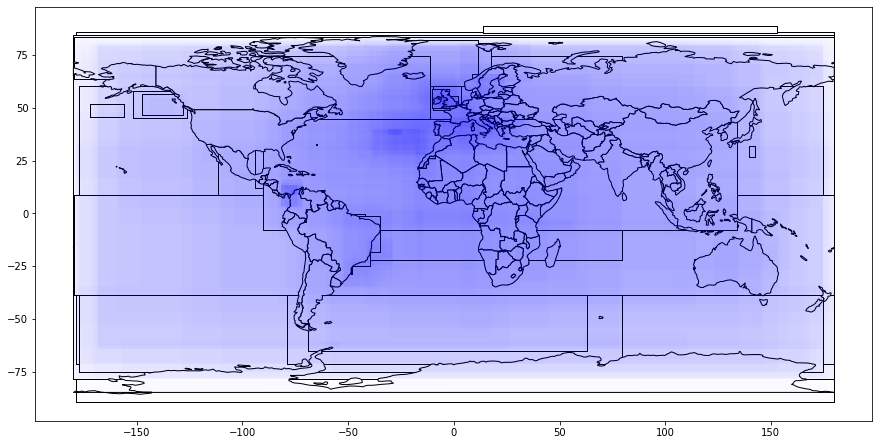

In [87]:
counties = "https://raw.githubusercontent.com/deldersveld/topojson/master/world-countries.json"
cgpd = gpd.read_file(counties)

combined = gdf.append(cgpd)
ax = combined.plot(color='white', edgecolor='black', figsize=(15,15))

# ax = gdf.plot(color='white', edgecolor='black', figsize=(15,15))
combined.plot(ax=ax, color='blue', alpha=0.010) # We can now plot our ``GeoDataFrame``.

In [86]:
gdf.to_file("./output/oih_obis_wmo.geojson", driver='GeoJSON')

## Full product

In this section we will loop over the files, load them and query and then save to parquet


In [20]:
for u in urls:
    print("Loading {}".format(u))
    g = ConjunctiveGraph()
    g.parse(u, format="nquads")
    print(len(g))
    namespaces = {
        "shacl":   "http://www.w3.org/ns/shacl#" ,
        "schema":   "https://schema.org/" ,
        "schemawrong": "http://schema.org/",
        "geo":      "http://www.opengis.net/ont/geosparql#",
    }

    # get the name of the provider from the release graph file name
    result = re.search('(?:summoned)(.*)(?:_v1_)', u)
    extracted_text = result.group(1)

    # import the file
    kg = kglab.KnowledgeGraph(name = "OIH test", base_uri = "https://oceaninfohub.org/id/", namespaces = namespaces, use_gpus=True, import_graph = g)

    # run the query
    pdf = kg.query_as_df(sparqlwmo)

    # add a column with the provider name in it
    pdf['provder'] = extracted_text

    # save to parquet
    pdf.to_parquet('./output/{}.parquet'.format(extracted_text))



Loading http://ossapi.oceaninfohub.org/public/graphs/summonedafricaioc_v1_release.nq
3193
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedaquadocs_v1_release.nq
1102997
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedcioos_v1_release.nq
145779
Loading http://ossapi.oceaninfohub.org/public/graphs/summonededmerp_v1_release.nq
73543
Loading http://ossapi.oceaninfohub.org/public/graphs/summonededmo_v1_release.nq
101850
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedemodnet_v1_release.nq
1245
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinanodc_v1_release.nq
499
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinvemardocuments_v1_release.nq
133485
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarexperts_v1_release.nq
14638
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinvemarinstitutions_v1_release.nq
3221
Loading http://ossapi.oceaninfohub.org/public/graphs/summonedinvemartraining_v1_relea

In [49]:
import pandas as pd

directory = './output'

# This will list all files in the directory that end with .parquet.
files = [f for f in os.listdir(directory) if f.endswith('.parquet')]

# Empty DataFrame to which we'll append each individual file.
combined_df = pd.DataFrame()

for file in files:
    # Complete file path.
    file_path = os.path.join(directory, file)

    # Read the parquet file.
    df = pd.read_parquet(file_path)

    # Append it to the combined DataFrame.
    combined_df = combined_df.append(df)

# If you want to write this combined DataFrame to a new Parquet file:
combined_df.to_parquet('oih_wmo_full.parquet')

In [45]:
combined_df['WKT'] = combined_df['geom'].apply(to_wkt)

In [46]:
combined_df['geometry'] = combined_df['WKT'].apply(wkt.loads)
gdf_combined = gpd.GeoDataFrame(combined_df, geometry='geometry')

In [47]:
gdf_combined.head(5)

,provder,s,name,description,geotype,geompred,geom,WKT,geometry
0,obis,<https://obis.org/dataset/1057a007-c31c-48a3-a...,Census of annual pup production by Australian ...,"In Australia, it is thought that up to 26 Aust...",schema:GeoShape,schema:polygon,"135.96667 -43.63333,135.96667 -35.01667,150.23...","POLYGON ((135.96667 -43.63333, 135.96667 -35.0...","POLYGON ((135.96667 -43.63333, 135.96667 -35.0..."
1,obis,<https://obis.org/dataset/d64477cf-491f-4de5-8...,Canary Islands - OAG (aggregated per 1-degree ...,Original provider:\nObservatorio Ambiental Gra...,schema:GeoShape,schema:polygon,"-74.5 5.5,-74.5 45.5,32.5 45.5,32.5 5.5,-74.5 5.5","POLYGON ((-74.5 5.5, -74.5 45.5, 32.5 45.5, 32...","POLYGON ((-74.50000 5.50000, -74.50000 45.5000..."
2,obis,<https://obis.org/dataset/e71d452f-615e-4654-b...,Virginia and Maryland Sea Turtle Research and ...,Original provider:\nVirginia Aquarium and Mari...,schema:GeoShape,schema:polygon,"-76.39647 36.58278,-76.39647 38.52142,-74.3984...","POLYGON ((-76.39647 36.58278, -76.39647 38.521...","POLYGON ((-76.39647 36.58278, -76.39647 38.521..."
3,obis,<https://obis.org/dataset/49f74e10-b23b-4aca-a...,"Species assemblages, biomass and regional habi...",Tow video and epibenthic sled collections were...,schema:GeoShape,schema:polygon,"124.05919 -15.94544,124.05919 -15.22044,124.69...","POLYGON ((124.05919 -15.94544, 124.05919 -15.2...","POLYGON ((124.05919 -15.94544, 124.05919 -15.2..."
4,obis,<https://obis.org/dataset/9a37fc55-1fc8-4c19-b...,PIROP Northwest Atlantic 1965-1992,Original provider:\nCanadian Wildlife Service\...,schema:GeoShape,schema:polygon,"-149.5667 -25.15,-149.5667 79.7833,18.5667 79....","POLYGON ((-149.5667 -25.15, -149.5667 79.7833,...","POLYGON ((-149.56670 -25.15000, -149.56670 79...."


In [52]:
gdf_combined.to_file("oih_combined_wmo.geojson", driver='GeoJSON')